In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [4]:
df_train = pd.read_excel(r'C:/Users/palit/Downloads/classification-of-tweets-from-northern-europe-fall2023/training_data.xlsx')
df_test = pd.read_excel(r'C:/Users/palit/Downloads/classification-of-tweets-from-northern-europe-fall2023/test_data.xlsx')

In [2]:
#df_train = pd.read_csv(r'C:/Users/palit/Downloads/training_data_cleaned.csv')
#df_test = pd.read_csv(r'C:/Users/palit/Downloads/test_data_cleaned.csv')

In [3]:
df_train.head()

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,clean_text
0,feminist AskMeAnything,b'RT @swedennewyork: What does it mean to have...,NaN,sweden,Male,Left,bRT swedennewyork mean feminist government Joi...
1,NaN,b'Jens Stoltenberg \xc3\xa5pnet virtuelle Rock...,NaN,norway,Male,Left,bJens Stoltenberg xc3xa5pnet virtuelle Rockhei...
2,NaN,b'@Panenka_Bart Veel beterschap Bart en Loes! ...,BartDerwael,belgium,Male,Left,bPanenka_Bart Veel beterschap Bart Loes xf0x9f...
3,NaN,b'RT @CarlEmilLind: Tydelige S aftryk: \n\nPsk...,NaN,denmark,Female,Left,bRT CarlEmilLind Tydelige aftryk nnPskykiatrie...
4,NaN,b'\xf0\x9f\x98\x83 https://t.co/bpqoZ8Y4wm',NaN,sweden,Male,Left,bxf0x9fx98x83


In [4]:
df_test.head()

,Id,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,clean_text
0,0,EUAfrica,"b'RT @eu_eeas: ""Let me tell you that a big par...",NaN,belgium,Male,NaN,bRT eu_eeas Let tell big part worlds future al...
1,1,COVID19,"b'RT @stateofgreendk: ""Although the #COVID19 p...",NaN,denmark,Male,NaN,bRT stateofgreendk Although COVID19 pandemic o...
2,2,NaN,b'@hjorvarhaflida // jebb - i\xc3\xb0a\xc3\xb0...,hjorvarhaflida,iceland,Female,NaN,bhjorvarhaflida jebb ixc3xb0axc3xb0i xc3xa1 me...
3,3,NaN,"b'I ett l\xc3\xa4ge med pandemi, klimat, trans...",NaN,sweden,Female,NaN,bI ett lxc3xa4ge med pandemi klimat transportv...
4,4,UNGA ChildrenNotSoldiers,b'RT @BelgiumMFA: \xf0\x9f\x93\x8d #UNGA\n\n\x...,NaN,belgium,Male,NaN,bRT BelgiumMFA xf0x9fx93x8d UNGAnnxf0x9fx92xac...


### Section-A

### a) Min, max, avg, median of tweets and hashtag length

In [ ]:
# Compute length in characters and words for 'text'
df_train['text_char_length'] = df_train['full_text'].str.len()
df_train['text_word_length'] = df_train['full_text'].str.split().str.len()

# Compute length in characters and words for 'hashtags'
df_train['hashtags_char_length'] = df_train['hashtags'].str.len()
df_train['hashtags_word_length'] = df_train['hashtags'].str.split().str.len()

# Calculate desired statistics
stats = {
    'text_char': ['text_char_length'],
    'text_word': ['text_word_length'],
    'hashtags_char': ['hashtags_char_length'],
    'hashtags_word': ['hashtags_word_length']
}

summary = {}
for key, value in stats.items():
    summary[f"{key}_min"] = df_train[value].min()[0]
    summary[f"{key}_avg"] = df_train[value].mean()[0]
    summary[f"{key}_median"] = df_train[value].median()[0]
    summary[f"{key}_max"] = df_train[value].max()[0]

result_df1 = pd.DataFrame([summary])
result_df1


### b) Top 10 most commonly used hashtags for each country

In [ ]:
# Split 'hashtags' column and explode to get each hashtag separately
df2 = df_train.assign(hashtags=df['hashtags'].str.split()).explode('hashtags')
df2


In [ ]:
# Group by 'country' and 'hashtags' and count frequency
hashtag_count = df2.groupby(['country_user', 'hashtags']).size().reset_index(name='count')
# get top 10 hashtags for each country along woth their counts
top_hashtags = hashtag_count.groupby('country_user').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)
top_hashtags

In [ ]:
#plot a pie chart for each country_user and their hanshtags and count
for country in top_hashtags['country_user'].unique():
    plt.figure(figsize=(5, 5))
    plt.pie(top_hashtags[top_hashtags['country_user'] == country]['count'], labels=top_hashtags[top_hashtags['country_user'] == country]['hashtags'], autopct='%1.1f%%')
    plt.title(f"Top 10 hashtags for {country}")
    plt.show()

### c) Stacked bar chart for percentage of political views associated with each country

In [ ]:
# Group by 'country_user' and 'pol_spec_user' and percentage of each pol_spec_user
pol_spec_user_count = df_train.groupby(['country_user', 'pol_spec_user']).size().reset_index(name='count')
pol_spec_user_count['percentage'] = pol_spec_user_count.groupby('country_user')['count'].apply(lambda x: x/x.sum()*100)
pol_spec_user_count

In [ ]:
pol_spec_user_count = pd.pivot_table(data=pol_spec_user_count, index=['country_user'], columns=['pol_spec_user'], values='percentage')
pol_spec_user_count

In [ ]:
#plot a stacked bar chart per country from country_user and their pol_spec_user and percentage
plot = pol_spec_user_count.plot.bar(stacked=True, figsize=(5,5))
plt.show()



### d) Stacked bar chart for distribution of genders by country.

In [ ]:
#Group by 'country_user' and 'gender_user'
gender = df_train.groupby(['country_user','gender_user']).size().reset_index(name='count')
gender['percentage'] = gender.groupby('country_user')['count'].apply(lambda x: x/x.sum()*100)
gender = pd.pivot_table(data=gender, index=['country_user'], columns=['gender_user'], values='percentage')
gender

In [ ]:
#plot a stacked bar chart per country from country_user and their gender and percentage
plot = gender.plot.bar(stacked=True, figsize=(5,5))
plt.show()

### Section-B

### a) Text Cleaner

In [8]:
#creating a function for cleaning tweet words 
def text_cleaner(text):
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word.lower() not in stop_words])

    # Remove words shorter than 3 characters
    text = " ".join([word for word in text.split() if len(word) >= 3])

    # Remove links starting with https
    text = re.sub(r'https\S+', '', text)

    # Remove Emojis
    emoji_pattern = re.compile(r"["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F700-\U0001F77F" 
                               u"\U0001F780-\U0001F7FF"  
                               u"\U0001F800-\U0001F8FF"  
                               u"\U0001F900-\U0001F9FF"  
                               u"\U0001FA00-\U0001FA6F"  
                               u"\U0001FA70-\U0001FAFF"  
                               u"\U0001FB00-\U0001FBFF"  
                               u"\U0001FC00-\U0001FCFF"  
                               u"\U0001FD00-\U0001FDFF"  
                               u"\U0001F700-\U0001F77F"  
                               u"\U0001FE00-\U0001FEFF"  
                               u"\U0001FF00-\U0001FFFF"  
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text
    

In [9]:
lemmatizer = WordNetLemmatizer()
##Tags the words in the tweets
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(wordnet.ADV)
    else:          
        return(None)

##Lemmatizes the words in tweets and returns the cleaned and lemmatized tweet
def lemmatize_tweet(tweet):
    #tokenize the tweet and find the POS tag for each token
    tweet = text_cleaner(tweet) #tweet_cleaner() will be the function you will write
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_tweet.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
    return(" ".join(lemmatized_tweet))

In [10]:
df_train['text_clean'] = df_train['full_text'].apply(lemmatize_tweet)
df_train

,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,clean_text
0,feminist AskMeAnything,b'RT @swedennewyork: What does it mean to have...,NaN,sweden,Male,Left,bRT swedennewyork mean feminist government Joi...
1,NaN,b'Jens Stoltenberg \xc3\xa5pnet virtuelle Rock...,NaN,norway,Male,Left,bJens Stoltenberg xc3xa5pnet virtuelle Rockhei...
2,NaN,b'@Panenka_Bart Veel beterschap Bart en Loes! ...,BartDerwael,belgium,Male,Left,bPanenka_Bart Veel beterschap Bart Loes xf0x9f...
3,NaN,b'RT @CarlEmilLind: Tydelige S aftryk: \n\nPsk...,NaN,denmark,Female,Left,bRT CarlEmilLind Tydelige aftryk nnPskykiatrie...
4,NaN,b'\xf0\x9f\x98\x83 https://t.co/bpqoZ8Y4wm',NaN,sweden,Male,Left,bxf0x9fx98x83
...,...,...,...,...,...,...,...
407218,NaN,b'RT @AnnLinde: It is unacceptable of Russia t...,NaN,sweden,Female,Left,bRT AnnLinde unacceptable Russia violate Swedi...
407219,NaN,b'RT @KirkensNodhjelp: Klimaendringer \xc3\xb8...,NaN,norway,Male,Center,bRT KirkensNodhjelp Klimaendringer xc3xb8ker r...
407220,dkpol,b'\xc3\x85rsopg\xc3\xb8relse! OBS!\xf0\x9f\x91...,NaN,denmark,Male,Left,bxc3x85rsopgxc3xb8relse OBSxf0x9fx91x87xf0x9fx...
407221,NaN,b'@VenstreRebekka @danielrugaas @ErlendHorn @...,RebekkaBorsch,norway,Female,Center,bVenstreRebekka danielrugaas ErlendHorn Roteva...


In [11]:
df_test['text_clean'] = df_test['full_text'].apply(lemmatize_tweet)
df_test

,Id,hashtags,full_text,in_reply_to_screen_name,country_user,gender_user,pol_spec_user,clean_text
0,0,EUAfrica,"b'RT @eu_eeas: ""Let me tell you that a big par...",NaN,belgium,Male,NaN,bRT eu_eeas Let tell big part worlds future al...
1,1,COVID19,"b'RT @stateofgreendk: ""Although the #COVID19 p...",NaN,denmark,Male,NaN,bRT stateofgreendk Although COVID19 pandemic o...
2,2,NaN,b'@hjorvarhaflida // jebb - i\xc3\xb0a\xc3\xb0...,hjorvarhaflida,iceland,Female,NaN,bhjorvarhaflida jebb ixc3xb0axc3xb0i xc3xa1 me...
3,3,NaN,"b'I ett l\xc3\xa4ge med pandemi, klimat, trans...",NaN,sweden,Female,NaN,bI ett lxc3xa4ge med pandemi klimat transportv...
4,4,UNGA ChildrenNotSoldiers,b'RT @BelgiumMFA: \xf0\x9f\x93\x8d #UNGA\n\n\x...,NaN,belgium,Male,NaN,bRT BelgiumMFA xf0x9fx93x8d UNGAnnxf0x9fx92xac...
...,...,...,...,...,...,...,...,...
101803,101803,NaN,b'En dag i valstugan uppfylld av alla unga str...,NaN,sweden,Female,NaN,bEn dag valstugan uppfylld alla unga strxc3xb6...
101804,101804,socialSummit17,b'It\xe2\x80\x99s great! Political commitment ...,NaN,denmark,Female,NaN,bItxe2x80x99s great Political commitment equal...
101805,101805,NaN,b'RT @DRNyheder: Skatteudspil har en lille eff...,NaN,denmark,Female,NaN,bRT DRNyheder Skatteudspil har lille effekt px...
101806,101806,DKpol,b'RT @MetteZoulamian: K\xc3\xa6re politikere t...,NaN,denmark,Male,NaN,bRT MetteZoulamian Kxc3xa6re politikere tag je...


In [12]:
# Compute length in characters and words for 'text'
df_train['clean_text_char_length'] = df_train['text_clean'].str.len()
df_train['clean_text_word_length'] = df_train['text_clean'].str.split().str.len()

# Compute length in characters and words for 'hashtags'
df_train['hashtags_char_length'] = df_train['hashtags'].str.len()
df_train['hashtags_word_length'] = df_train['hashtags'].str.split().str.len()

# Calculate desired statistics
stats = {
    'text_char': ['clean_text_char_length'],
    'text_word': ['clean_text_word_length'],
    'hashtags_char': ['hashtags_char_length'],
    'hashtags_word': ['hashtags_word_length']
}

summary = {}
for key, value in stats.items():
    summary[f"{key}_min"] = df_train[value].min()[0]
    summary[f"{key}_avg"] = df_train[value].mean()[0]
    summary[f"{key}_median"] = df_train[value].median()[0]
    summary[f"{key}_max"] = df_train[value].max()[0]

result_df2 = pd.DataFrame([summary])
result_df2

result_df= pd.merge(result_df1, result_df2)


### b) LDA and NMF

In [12]:
#%pip install --upgrade scikit-learn

     ---------------------------------------- 9.3/9.3 MB 18.6 MB/s eta 0:00:00
     ------------------------------------- 302.2/302.2 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Note: you may need to restart the kernel to use updated packages.


Extracting tf-idf features for NMF...
done in 10.234s.
Extracting tf features for LDA...
done in 10.267s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 14.913s.


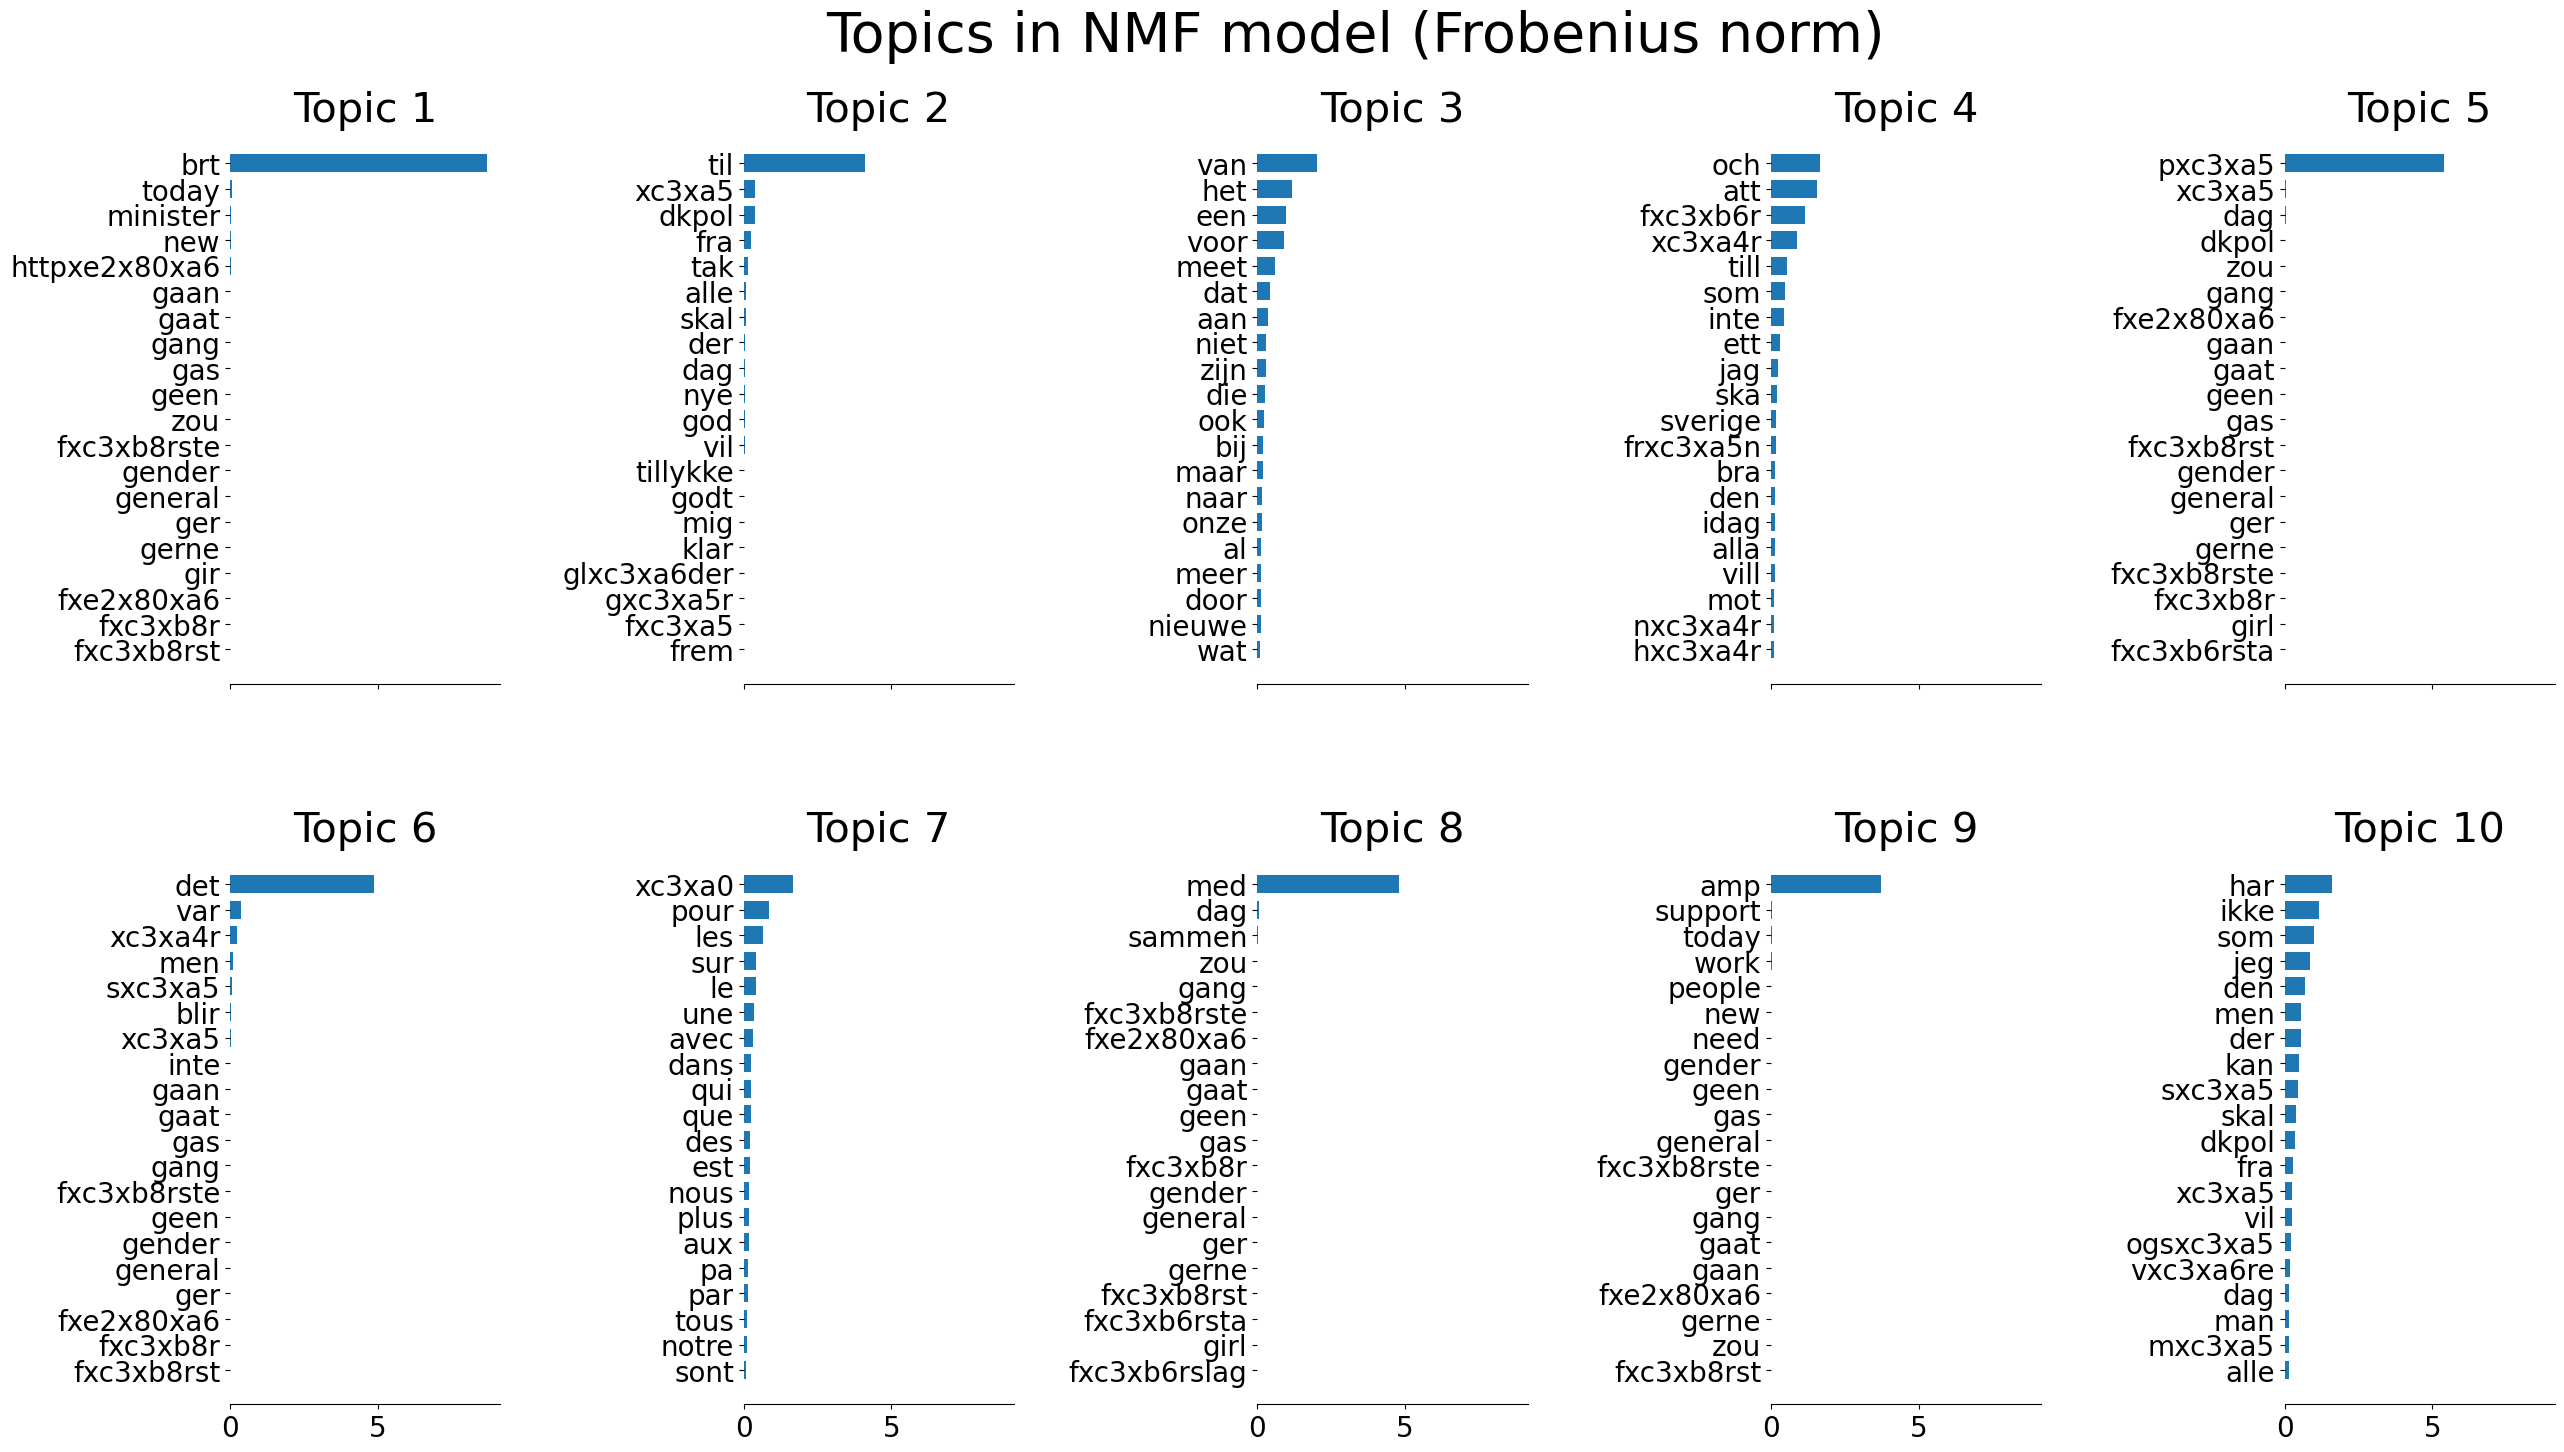

done in 432.310s.


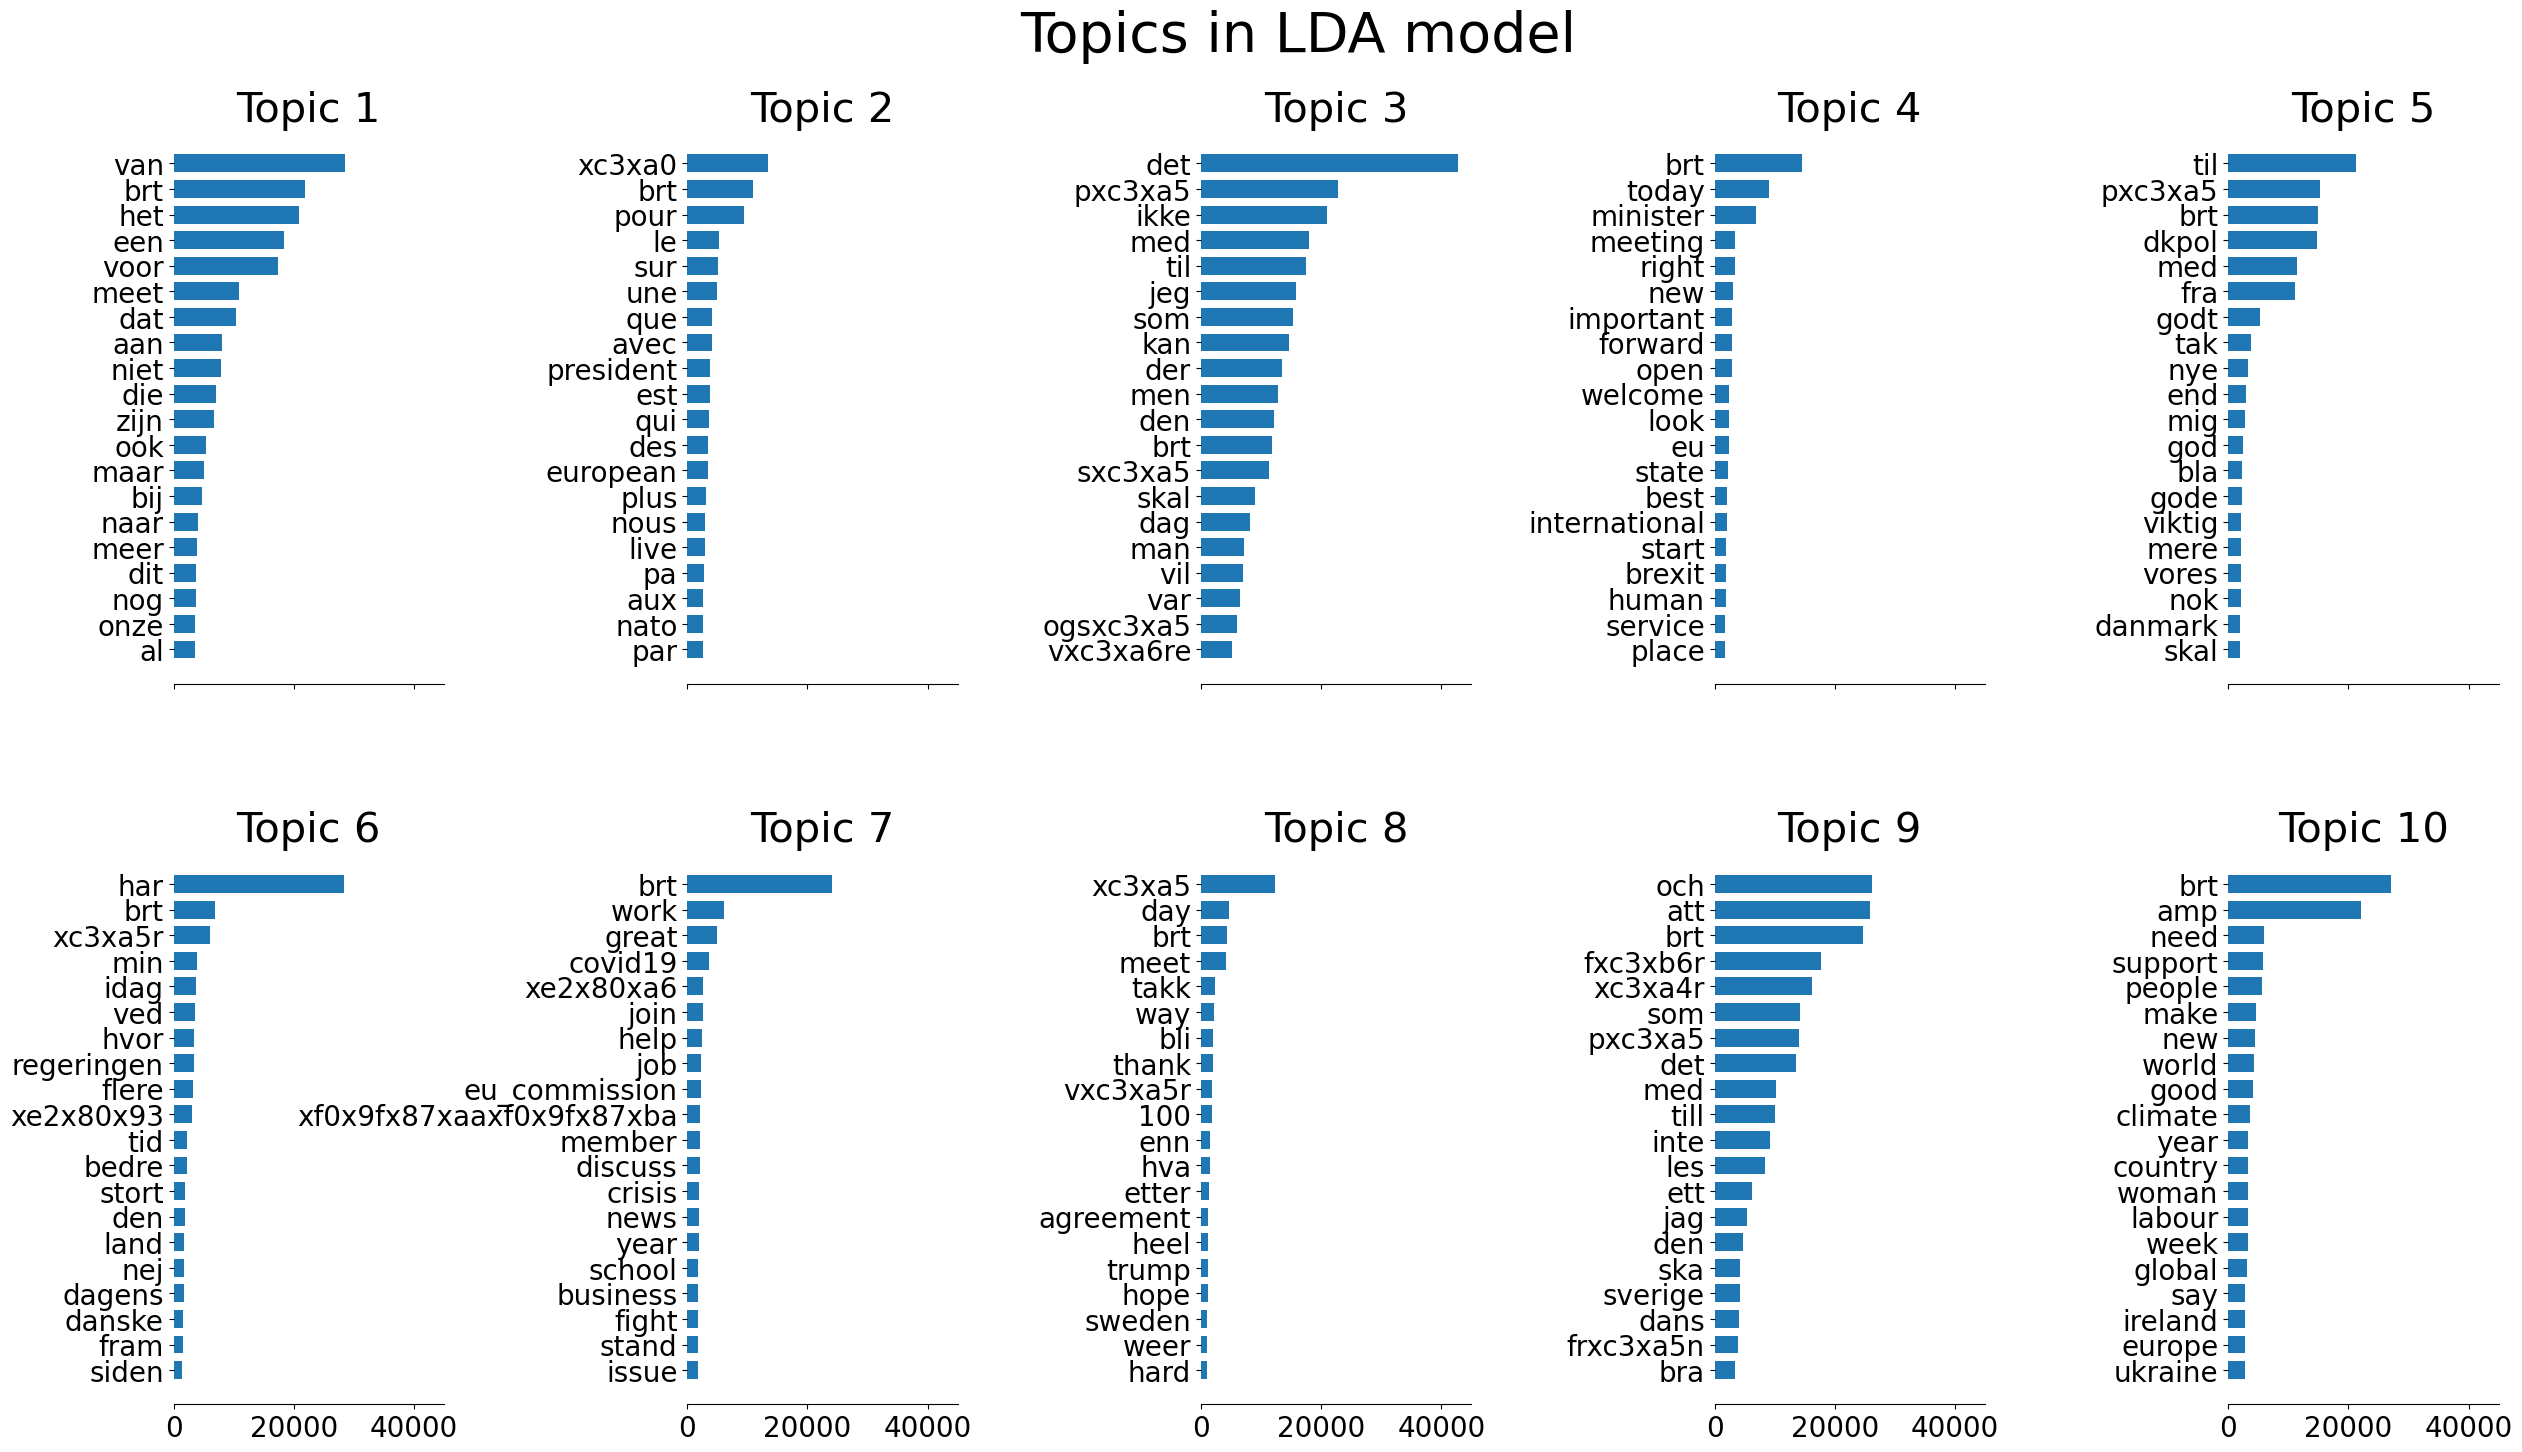

In [5]:
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
# X = tfidf_vectorizer.fit_transform(df_train['clean_text'])

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(df_train['text_clean'])
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(df_train['text_clean'])
print("done in %0.3fs." % (time() - t0))
print()



# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)



lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

### Model Creation

In [27]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import accuracy_score

# # Prepare your data
# X = df_train['text_clean']
# y = df_train['pol_spec_user'].map({
#     'Center': 0,
#     'Left': 1,
#     'Right': 2,
#     'Independent': 3
# })

# # Convert texts into TF-IDF vectors
# vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
# X_transformed = vectorizer.fit_transform(X)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)


# # Initialize the Logistic Regression classifier and train
# clf = LogisticRegression(max_iter=1000, random_state=42)
# clf.fit(X_train, y_train)

# # Predict on the test data
# y_pred = clf.predict(X_test)

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")



In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

tf = tf_vectorizer.transform(df_train['text_clean'])
topic_distributions = lda.transform(tf)

from scipy.sparse import hstack

# Prepare your data
X = df_train['text_clean']
y = df_train['pol_spec_user'].map({
    'Center': 0,
    'Left': 1,
    'Right': 2,
    'Independent': 3
})


# Get TF-IDF features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.7)
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Combine TF-IDF features with topic distributions
X_combined = hstack([X_tfidf, topic_distributions])

# Split combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Define search space for GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

# Use GridSearchCV to find best hyperparameters
clf = LinearSVC(random_state=42, max_iter=5000)
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Predict and evaluate
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 75.12%


In [10]:
submission_df = pd.read_csv('C:/Users/palit/Downloads/classification-of-tweets-from-northern-europe-fall2023/sample_submission.csv')

In [11]:
# Transform the text data using the CountVectorizer and LDA model
tf_test = tf_vectorizer.transform(df_test['text_clean'])
topic_distributions_test = lda.transform(tf_test)

# Get TF-IDF features for the test data
X_tfidf_test = tfidf_vectorizer.transform(df_test['text_clean'])

# Combine the TF-IDF features with the LDA topic distributions
X_combined_test = hstack([X_tfidf_test, topic_distributions_test])

# Use the best model from grid search to make predictions on the test set
test_predictions = grid_search.predict(X_combined_test)

# If you want to map predictions back to their original labels
label_mapping_reverse = {
    0: 'Center',
    1: 'Left',
    2: 'Right',
    3: 'Independent'
}
predicted_labels = [label_mapping_reverse[pred] for pred in test_predictions]

# Add predictions to the test DataFrame
submission_df['pol_spec_user'] = predicted_labels

submission_df.head()

,Id,pol_spec_user
0,0,Left
1,1,Left
2,2,Left
3,3,Left
4,4,Center


In [12]:
submission_df.to_csv('C:/Users/palit/Downloads/classification-of-tweets-from-northern-europe-fall2023/sample_submissions_4.csv', index=False)